# Phenotype generation

Genotype data comes from the [PLINK tutorial](http://zzz.bwh.harvard.edu/plink/tutorial.shtml) and can be downloaded from http://zzz.bwh.harvard.edu/plink/hapmap1.zip 

Create the folder `data` and unzip `hapmap1.zip` in it.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
ped = np.loadtxt("data/hapmap1.ped", usecols=xrange(6, 167074), dtype=int)

In [55]:
# naively impute missing values by replacing them with 2 (major allele)
# in real life, please use IMPUTE2
ped[ped==0]=2

In [56]:
ped_start = np.loadtxt("data/hapmap1.ped", usecols=xrange(0, 6), dtype=str)
print ped_start.shape

(89, 6)


In [57]:
print ped.shape
ped_full = np.hstack((ped_start, ped))
print ped_full.shape
print ped_full[:2, :10]

(89, 167068)
(89, 167074)
[['HCB181' '1' '0' '0' '1' '1' '2' '2' '2' '2']
 ['HCB182' '1' '0' '0' '1' '1' '2' '2' '1' '2']]


In [58]:
# Reexport data with naive imputation
np.savetxt("data/hapmap1mod.ped", ped_full, fmt='%s')

## Causal SNPs

In [59]:
# randomly pick 6 SNPs to be causal
np.random.seed(42)
causal_SNPs = list(np.random.randint(0, high=83534, size=6))
causal_SNPs.sort()
print causal_SNPs

[860, 6265, 15795, 54886, 76820, 82386]


In [60]:
# randomly pick 5 causal weights (SNP4 and SNP5 will be in epistasis)
np.random.seed(41)
#causal_weights = np.random.uniform(size=9)
#causal_weights = np.random.normal(size=5)
causal_weights = [0.252, -0.213, 0.273, 0.249, -0.220]
print ["%.3f" % w for w in causal_weights]

['0.252', '-0.213', '0.273', '0.249', '-0.220']


In [61]:
# transform ped into only causal features
print ped.shape
causal_X = np.array([4-(ped[:, idx*2]+ped[:, idx*2+1]) for idx in causal_SNPs]).T
print causal_X.shape

(89, 167068)
(89, 6)


In [62]:
causal_X[:, 4] = causal_X[:, 4]*causal_X[:, 5]

In [63]:
causal_X = np.delete(causal_X, 5, 1)
print causal_X.shape

(89, 5)


## Names of causal SNPs

In [64]:
import pandas as pd

In [65]:
df = pd.read_csv('data/hapmap1.map', delim_whitespace=True, header=None)

In [66]:
df.iloc[causal_SNPs]

,0,1,2,3
860,1,rs12045968,0,861
6265,1,rs967216,0,6266
15795,3,rs920160,0,15796
54886,11,rs1015896,0,54887
76820,18,rs1942455,0,76821
82386,22,rs1115764,0,82387


In [67]:
causal_SNPs_names = df.iloc[causal_SNPs][1].values
print causal_SNPs_names

['rs12045968' 'rs967216' 'rs920160' 'rs1015896' 'rs1942455' 'rs1115764']


In [2]:
causal_SNPs_names = ['rs12045968', 'rs967216', 'rs920160', 'rs1015896', 'rs1942455', 'rs1115764']

## Generating case/control phenotype

In [ ]:
y = np.dot((-2*causal_X+3), causal_weights)+0.5
print y.shape

In [ ]:
print y

In [ ]:
p = np.exp((y))/(np.exp((y))+1)
hist(p)

In [ ]:
phe = p>0.5

In [ ]:
phe = np.array(phe, dtype=int)
print np.sum(phe), 89-np.sum(phe)

## Generating quantitative phenotype

In [ ]:
phe = np.dot(causal_X, causal_weights)+0.1*np.random.random(size=causal_X.shape[0])

In [ ]:
print phe.shape
y_true = np.dot(causal_X, causal_weights)

In [ ]:
plt.scatter(y_true, phe)

## Code new phenotype file

In [ ]:
# Read sample names
sample_names = np.loadtxt('data/qt.phe', usecols=0, dtype='S')

In [ ]:
# Write phenotype file, using pandas
import pandas as pd

In [ ]:
df = pd.DataFrame(index=range(y.shape[0]), columns=('FID', 'IID', 'PHENOTYPE'))

In [ ]:
df.FID=sample_names

In [ ]:
df.IID = np.array(np.ones(89, ), dtype='int')

In [ ]:
df.PHENOTYPE = phe

In [ ]:
df.to_csv('data/phenotype.phe', header=False, index=False, sep=" ")

Recode the phenotype in the .ped file
``` 
plink --map hapmap1.map --ped hapmap1mod.ped --pheno phenotype.phe --recode --noweb --out simulated
```

## PLINK

```
plink --noweb --file simulated --maf 0.01 --hwe 1e-6 --geno 0.1 --make-bed --out mydata

plink --noweb --bfile mydata

plink --noweb --bfile mydata --assoc --out assoc1

sort --key=8 -r --general-numeric-sort assoc1.assoc | head -20 # case/control
sort --key=8 -r --general-numeric-sort assoc1.qassoc | head -20 # quantitative

```

# Manipulate PLINK output

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('data/assoc1.qassoc', # File name
                 delim_whitespace=True) # Use any white space as delimiter

In [7]:
# sort df by p-value
df_sorted = df.sort_values('P')
print df_sorted[:10]

       CHR         SNP     BP  NMISS    BETA       SE      R2      T  \
43968   11   rs1015896  54887     89 -0.2669  0.03154  0.4516 -8.464   
12345    3    rs920160  15796     89  0.2401  0.03937  0.2995  6.099   
43970   11    rs524657  54889     89 -0.2093  0.04063  0.2336 -5.150   
683      1  rs12045968    861     89  0.2169  0.04525  0.2090  4.794   
13279    3   rs1403436  16984     89 -0.1889  0.04314  0.1806 -4.379   
19467    4   rs4279260  24660     89  0.1735  0.04041  0.1749  4.294   
13278    3   rs2470764  16983     89 -0.2028  0.04758  0.1728 -4.264   
13277    3   rs1905017  16982     89 -0.2028  0.04758  0.1728 -4.264   
49603   13   rs1467601  61964     89  0.1739  0.04118  0.1701  4.223   
43973   11   rs2283233  54892     89 -0.1554  0.03732  0.1662 -4.164   

                  P  
43968  5.608000e-13  
12345  2.870000e-08  
43970  1.602000e-06  
683    6.696000e-06  
13279  3.308000e-05  
19467  4.548000e-05  
13278  5.089000e-05  
13277  5.089000e-05  
49603  5.

## Scores for causal SNPs

In [8]:
df.loc[df['SNP'].isin(causal_SNPs_names)]

,CHR,SNP,BP,NMISS,BETA,SE,R2,T,P
683,1,rs12045968,861,89,0.216900,0.04525,2.090000e-01,4.794000,6.696000e-06
4891,1,rs967216,6266,89,-0.145700,0.21170,5.418000e-03,-0.688500,4.930000e-01
12345,3,rs920160,15796,89,0.240100,0.03937,2.995000e-01,6.099000,2.870000e-08
43968,11,rs1015896,54887,89,-0.266900,0.03154,4.516000e-01,-8.464000,5.608000e-13
61140,18,rs1942455,76821,89,0.019130,0.11000,3.479000e-04,0.174000,8.623000e-01
65596,22,rs1115764,82387,89,-0.000265,0.11690,5.931000e-08,-0.002272,9.982000e-01


## Manhattan plot

(0, 83534)

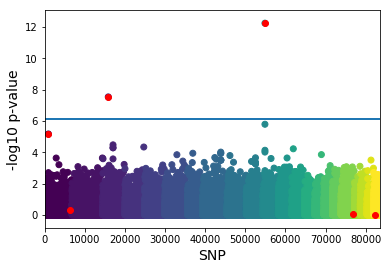

In [9]:
fig = plt.figure(figsize(6, 4))

plt.scatter(df.BP, # x = SNP position
            -np.log10(df.P), # y = -log10 p-value (the higher the more significant)
            c=df.CHR) # color by chromosome

# Plot the causal SNPs in red
plt.scatter(df.BP[df['SNP'].isin(causal_SNPs_names)], 
            -np.log10(df.P[df['SNP'].isin(causal_SNPs_names)]),
                     color='red')

# significance threshold according to Bonferroni correction
t = -np.log10(0.05/df.shape[0])
plt.plot([0, max(df.BP)], [t, t], lw=2)

plt.xlabel("SNP", fontsize=14)
plt.ylabel("-log10 p-value", fontsize=14)
plt.xlim([0, max(df.BP)])

#plt.savefig('manhattan.png', bbox_inches='tight')


Note how the SNP just below significance (between 50 000 and 60 000) is not actually causal in the simulation.

In [10]:
# names of significant SNPs
sig_SNPs = df.SNP[df.P < 0.05/df.shape[0]]
print sig_SNPs

12345     rs920160
43968    rs1015896
Name: SNP, dtype: object


## Q-Q plot

In [11]:
import scipy.stats as ss

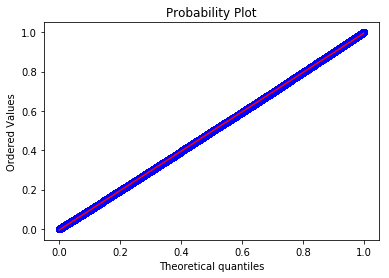

In [12]:
ss.probplot(df.P, dist="uniform", plot=pylab)
plt.show()

# ML approaches
## Load data for ML

```
plink --noweb --bfile mydata --recodeA --out mydata1
```

In [13]:
df = pd.read_csv('data/mydata1.raw', delim_whitespace=True)

In [14]:
y = df.PHENOTYPE.values

In [15]:
X = df.iloc[:, 6:].values

In [16]:
X.shape

(89, 66536)

In [17]:
y.shape

(89,)

In [18]:
# Rename SNP columns to get rid of the last two characters
new_col_names = list(df.columns[:6])
new_col_names.extend([col_name[:-2] for col_name in df.columns[6:]])
df.columns = new_col_names

In [19]:
print df.columns

Index([u'FID', u'IID', u'PAT', u'MAT', u'SEX', u'PHENOTYPE', u'rs6681049',
       u'rs4074137', u'rs1891905', u'rs9729550',
       ...
       u'rs7410608', u'rs4824149', u'rs4824157', u'rs131817', u'rs131794',
       u'rs5770913', u'rs131750', u'rs2269380', u'rs1001469', u'rs756638'],
      dtype='object', length=66542)


## Percentage of variance explained by the most significant SNP

In [20]:
from sklearn import linear_model, metrics

In [21]:
# Restrict X to the one column corresponding to the most significant SNP.
# Need to remove 6 when taking the indices because the first 6 columns are not in X.

X_r = X[:, (df.columns.get_loc('rs1015896')-6)]
# reshape X_r as a 2D (column) array
X_r = np.atleast_2d(X_r).T
print X_r.shape

m = linear_model.LinearRegression(fit_intercept=True)
m.fit(X_r, y)
y_pred = m.predict(X_r)
print metrics.r2_score(y, y_pred)
print metrics.explained_variance_score(y, y_pred)

(89, 1)
0.451592085058
0.451592085058


Note this matches the PLINK output (R2 column).

## Percentage of variance explained by the two significant SNPs

In [23]:
# Restrict X to the two columns corresponding to the two significant SNPs.
# Need to remove 6 when taking the indices because the first 6 columns are not in X.
sig_indices = [(df.columns.get_loc(snp)-6) for snp in sig_SNPs]
X_sig = X[:, sig_indices]
print X_sig.shape

(89, 2)


In [24]:
# Create a linear model that uses the two significant SNPs and no intercept
model = linear_model.LinearRegression(fit_intercept=True)

In [25]:
# Fit model to data
model.fit(X_sig, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
# Make predictions with model
y_pred = model.predict(X_sig)

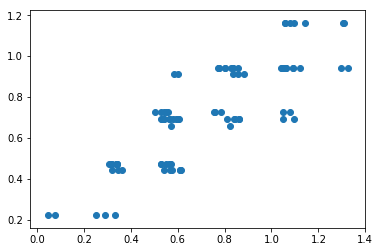

In [27]:
# Visualize predictions against true values
plt.scatter(y, y_pred)

In [28]:
# Percentage of variance explained
print metrics.explained_variance_score(y, y_pred)

0.566287883435


In [29]:
print metrics.r2_score(y, y_pred)

0.697490094731


## Lasso (no cross-validation)

In [30]:
from sklearn import linear_model

In [31]:
lasso = linear_model.Lasso(alpha=0.02)

In [32]:
lasso.fit(X, y)

Lasso(alpha=0.02, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [33]:
print np.where(lasso.coef_)[0]
print len(np.where(lasso.coef_)[0])

[  683 12345 19480 37206 43968 48589]
6


In [34]:
#causal_SNPs_indices = [df.columns.get_loc('%s_1' % snp) for snp in causal_SNPs_names]
print causal_SNPs_names
causal_SNPs_indices = []
for snp in causal_SNPs_names:
    try:
        causal_SNPs_indices.append(df.columns.get_loc(snp)-6) 
        # remove 6 because X starts at the 6th column of the df
    except KeyError:
        print "Did not find SNP %s" % snp
        continue
print causal_SNPs_indices

['rs12045968', 'rs967216', 'rs920160', 'rs1015896', 'rs1942455', 'rs1115764']
[683, 4891, 12345, 43968, 61140, 65596]


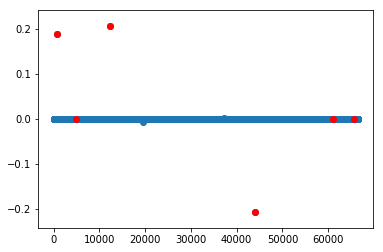

In [35]:
plt.scatter(range(lasso.coef_.shape[0]), # x = SNP position
            lasso.coef_, # y = SNP weight (the higher the more important)
            )

# Plot the causal SNPs in red
plt.scatter(causal_SNPs_indices, 
            lasso.coef_[causal_SNPs_indices],
                     color='red')

### Percentage of variance explained

In [36]:
selected_snps = np.where(lasso.coef_)[0]
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X[:, selected_snps], y)
y_pred = model.predict(X[:, selected_snps])

In [37]:
# Make predictions with model
y_pred = lasso.predict(X)

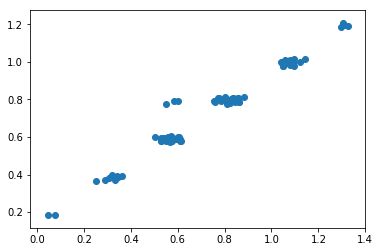

In [38]:
# Visualize predictions against true values
plt.scatter(y, y_pred)

In [39]:
# Percentage of variance explained
print metrics.explained_variance_score(y, y_pred)

0.938896281278


## Lasso (cross-validation of the regularization parameter)

In [40]:
lasso_cv = linear_model.LassoCV(cv=5)

In [41]:
lasso_cv.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [42]:
print np.where(lasso_cv.coef_)[0]
print len(np.where(lasso_cv.coef_)[0])

[  683  2187  4843  9759 10274 11504 12345 19480 23952 27323 30861 31243
 31244 32255 33344 34052 36614 37206 40259 43512 43968 48263 48356 48589
 50634 50653 52697 56137 57451 60661 63720 65049]
32


In [43]:
print lasso_cv.alpha_

0.0102747091608


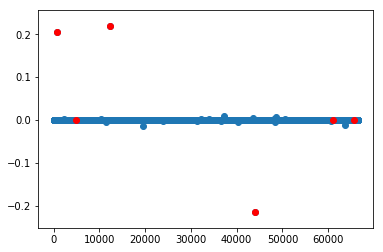

In [45]:
plt.scatter(range(lasso_cv.coef_.shape[0]), # x = SNP position
            lasso_cv.coef_, # y = SNP weight (the higher the more important)
            )

# Plot the causal SNPs in red
plt.scatter(causal_SNPs_indices, 
            lasso_cv.coef_[causal_SNPs_indices],
                     color='red')

In [46]:
# Make predictions with model
y_pred = lasso_cv.predict(X)

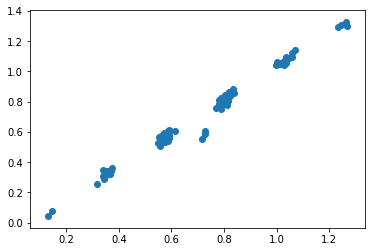

In [47]:
# Visualize predictions against true values
plt.scatter(y_pred, y)

In [48]:
# Percentage of variance explained
print metrics.explained_variance_score(y, y_pred)

0.972092454965


## Cross-validation and percentage of variance explained on a held-out test set

In [49]:
from sklearn import model_selection
X_disc, X_val, y_disc, y_val = model_selection.train_test_split(X, y, test_size=0.33, 
                                                                    random_state=42)

In [50]:
lasso_cv = linear_model.LassoCV(cv=3)
lasso_cv.fit(X_disc, y_disc)

LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [51]:
print "Optimal alpha:", lasso_cv.alpha_

Optimal alpha: 0.0168711026929


In [52]:
selected_snps = np.where(lasso_cv.coef_)[0]
print len(selected_snps)

18


In [53]:
# Fit a linear model to the significant SNPs
model = linear_model.LinearRegression()
model.fit(X_disc[:, selected_snps], y_disc)
# Predict on the discovery set
y_pred = model.predict(X_disc[:, selected_snps])

# Percentage of variance explained
print metrics.explained_variance_score(y_pred, y_disc)

0.994008986493


In [54]:
# Use the model to predict on the validation set
y_pred = model.predict(X_val[:, selected_snps])

# Percentage of variance explained
print metrics.explained_variance_score(y_pred, y_val)

0.895305685533
